# Twitter Sentiment Analysis

## Imports

In [1]:
import os
import pandas as pd
from utils import get_dataset, plot_label_distribution
from preprocessing import data_preprocessing, get_X_y

## Explore data

In [2]:
# Retrieves dataset
paths = [os.path.join(os.getcwd(), "dataset/twitter_training.csv"), os.path.join(os.getcwd(), "dataset/twitter_validation.csv")]
data = get_dataset(paths)
data.head()

,id,topic,label,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      75682 non-null  int64 
 1   topic   75682 non-null  object
 2   label   75682 non-null  object
 3   tweet   74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
# Data preprocessing : text preprocessing, row deletion if there is no text, encodes the label column, etc.
data = data_preprocessing(data)
data.head()

,id,topic,label,tweet,Preprocessed tweet,Encoded label
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder,3
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill,3
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill,3
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderland murder,3
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder,3


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74996 entries, 0 to 75681
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  74996 non-null  int64 
 1   topic               74996 non-null  object
 2   label               74996 non-null  object
 3   tweet               74996 non-null  object
 4   Preprocessed tweet  74996 non-null  object
 5   Encoded label       74996 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 4.0+ MB


/home/cytech/code_project/machine_learning/classification/multiclass/twitter_sentiment_analysis/utils.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


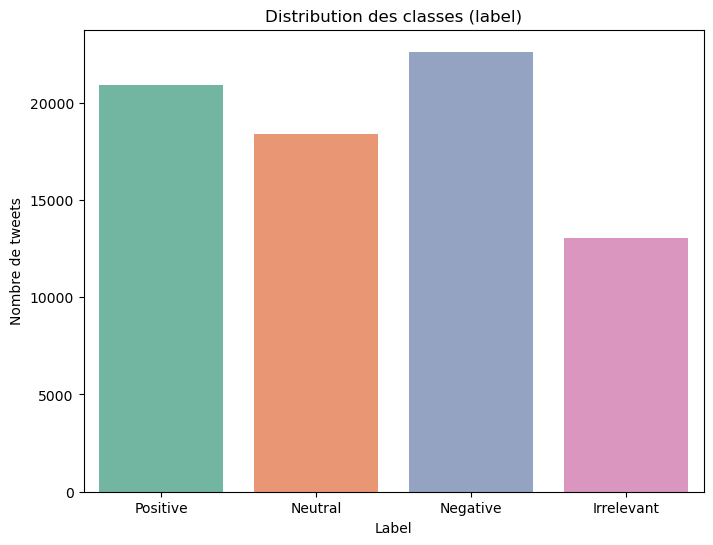

In [6]:
plot_label_distribution(data)

In [7]:
data["label"].value_counts() / len(data)

label
Negative      0.301669
Positive      0.279108
Neutral       0.245253
Irrelevant    0.173969
Name: count, dtype: float64

Based on the provided label distribution, we can observe the following insights:

- Negative Sentiment Dominance: The highest proportion of tweets is categorized as Negative (30.17%). This suggests a prevalent sentiment of dissatisfaction or criticism among the tweets analyzed.

- Positive Sentiment: The Positive label follows closely behind at 27.91%. While there is a notable amount of positive feedback, it is still overshadowed by the negative sentiment.

- Neutral and Irrelevant Sentiments: The Neutral and Irrelevant categories have lower proportions at 24.53% and 17.40%, respectively. This indicates that a significant portion of the tweets does not express a strong opinion or is off-topic, which may dilute the overall sentiment analysis.

## Models

In [8]:
# Split dataset in features (X) and variables to be predicted (y)
X, y = get_X_y(data)
X.head()

,Preprocessed tweet
0,im getting borderland murder
1,coming border kill
2,im getting borderland kill
3,im coming borderland murder
4,im getting borderland murder


In [9]:
y

,Encoded label
0,3
1,3
2,3
3,3
4,3
...,...
75677,0
75678,0
75679,3
75680,3


### Training and Testing set

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

In [123]:
target = ["label"]
features = ["Preprocessed tweet"]

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train)
print(y_train)

                                      Preprocessed tweet
46708                                           wow know
12946                                nice rhandlerr nice
50856   dey always buy guy fifa career mode growth magic
36536                   live rossiya watch osg show back
57769  please explain sound cut middle damn game came...
...                                                  ...
271    girl fire end credit reason leave borderland f...
11406  xbox series x get hot journalist claim burnt h...
34901  fucking fortnitegame get wont remove sbmm club...
54913  callofduty new beta cold war ridiculously bad ...
31899                             riot like well lost lp

[59996 rows x 1 columns]
            label
46708    Positive
12946    Positive
50856  Irrelevant
36536     Neutral
57769    Negative
...           ...
271      Negative
11406     Neutral
34901    Negative
54913    Negative
31899     Neutral

[59996 rows x 1 columns]


The TfidfVectorizer is used to transform a text into a numerical representation by weighting each word according to its frequency in the document and its inverse in the set of documents, in order to favour terms specific to the text and reduce the importance of common terms.

In [61]:
# Features
ct = ColumnTransformer([
    ("text preprocessor", TfidfVectorizer(max_features=5000), "Preprocessed tweet")
])

### 1) Naive Bayes

In [62]:
# Encoding y
encoder = LabelEncoder()
y_train_ = encoder.fit_transform(y_train)
y_test_ = encoder.transform(y_test)

clf = Pipeline([
    ('preprocessing', ct),
    ('model', MultinomialNB())
])
clf.fit(X_train, y_train_)

/home/cytech/anaconda3/envs/ML_project/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cytech/anaconda3/envs/ML_project/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text preprocessor',
                                                  TfidfVectorizer(max_features=5000),
                                                  'Preprocessed tweet')])),
                ('model', MultinomialNB())])

In [44]:
y_pred_ = clf.predict(X_test)
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

           0       0.74      0.36      0.49      2609
           1       0.63      0.80      0.70      4525
           2       0.66      0.54      0.60      3679
           3       0.62      0.73      0.67      4187

    accuracy                           0.64     15000
   macro avg       0.66      0.61      0.61     15000
weighted avg       0.65      0.64      0.63     15000



**Precision:**

Precision measures the model's ability to correctly identify positive examples among those classified as positive.
For class 0, precision is very high at 0.94, meaning that when the model predicts class 0, it has a high probability of this prediction being correct.
Class 1, on the other hand, has an accuracy of 0.65, indicating that the model makes more errors when classifying examples that should be of other classes as belonging to class 1.
The other classes (2 and 3) have respective accuracies of 0.80 and 0.69, indicating intermediate performance.

**Recall:**

Recall (or sensitivity) indicates the model's ability to detect all positive examples for each class.
Class 1 has the best recall of 0.88, showing that the model identifies this class well, while class 0 has a recall of only 0.42, suggesting that many examples in class 0 are not detected.
Classes 2 and 3 show moderate recall values, with 0.62 and 0.80 respectively.

**F1-Score:**

The F1-score is the harmonic mean of precision and recall, providing an overall measure of model performance.
Class 1 has the best F1-score at 0.75, indicating a good balance between precision and recall. Classes 2 and 3 are also in an acceptable range, with F1-scores of 0.70 and 0.74 respectively, while class 0 has an F1-score of 0.58, indicating sub-optimal performance.

**Support:**

The support shows the number of real examples in each class. This gives an idea of the distribution of classes in the dataset.
Class 1 has the highest number of examples (4525), while class 0 has the lowest support (2609).

**Average Scores:**

- Accuracy: The overall accuracy of the model is 0.71, meaning that the model correctly predicted the class for 71% of the test instances. However, this masks a wide range of performance for each class.
- Macro Average: The macro averages for precision, recall and F1-score are 0.77, 0.68, and 0.69 respectively, indicating that, although performance is acceptable overall, there are significant variations between classes.
- Weighted Average: The weighted averages for these metrics are slightly lower, reflecting the importance of the more frequent classes in the overall results.

### 2) Random Forest Classifier

In [29]:
clf = Pipeline([
    ('preprocessing', ct),
    ('model', RandomForestClassifier())
])
clf.fit(X_train, y_train_)

/home/cytech/anaconda3/envs/ML_project/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text preprocessor',
                                                  TfidfVectorizer(),
                                                  'Preprocessed tweet')])),
                ('model', RandomForestClassifier())])

In [30]:
y_pred_ = clf.predict(X_test)
print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90      2609
    Negative       0.92      0.92      0.92      4525
     Neutral       0.86      0.92      0.89      3679
    Positive       0.90      0.91      0.90      4187

    accuracy                           0.91     15000
   macro avg       0.91      0.90      0.90     15000
weighted avg       0.91      0.91      0.91     15000



### 3) RNN

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

2024-10-16 18:33:14.329708: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 18:33:14.448550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# target, features
target = ["label"]
features = ["Preprocessed tweet"]

# X, y
X = data[features]
y = data[target]

# train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(47996, 1)
(12000, 1)
(15000, 1)


In [72]:
oe = OneHotEncoder()
y_train = oe.fit_transform(y_train).toarray()
y_val = oe.transform(y_val).toarray()
y_test = oe.transform(y_test).toarray()
y_test

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [73]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train["Preprocessed tweet"])
X_val = vectorizer.transform(X_val["Preprocessed tweet"])
X_test = vectorizer.transform(X_test["Preprocessed tweet"])
X_test.shape

(15000, 5000)

### 3.1) Simple RNN

In [92]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Nombre de classes = 4
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
# Modèle
clf_rnn = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)

# Entraînement avec le callback pour sauvegarder l'historique
clf_rnn.fit(X_train, y_train, validation_data=(X_val, y_val))

# Récupérer l'historique de l'entraînement
history = clf_rnn.history_

/home/cytech/anaconda3/envs/ML_project/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/cytech/anaconda3/envs/ML_project/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.5434 - loss: 1.0573 - val_accuracy: 0.7100 - val_loss: 0.7363
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8032 - loss: 0.5273 - val_accuracy: 0.8028 - val_loss: 0.5378
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9020 - loss: 0.2729 - val_accuracy: 0.8374 - val_loss: 0.4726
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9388 - loss: 0.1616 - val_accuracy: 0.8507 - val_loss: 0.4712
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9512 - loss: 0.1203 - val_accuracy: 0.8558 - val_loss: 0.4799
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9533 - loss: 0.1099 - val_accuracy: 0.8547 - val_loss: 0.5098
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9534 - loss: 0.1030 - val_accuracy: 0.8577 - val_loss: 0.5117
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9560 -

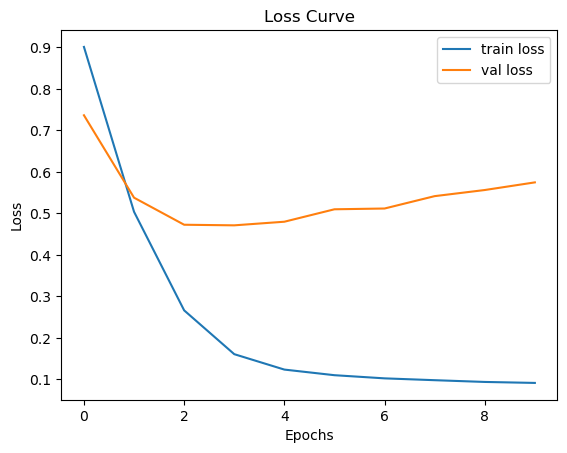

In [76]:
import matplotlib.pyplot as plt

# Tracer la courbe de la fonction de perte (loss)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

**Model Overfitting**:

The model shows signs of overfitting because, from epoch 5 onwards, the val_loss (loss on the validation set) stops falling and starts to stagnate or even increase (from 0.4712 to 0.4799), while the accuracy on the training set continues to increase. For example, the training accuracy rises from 0.9388 to 0.9512, but the validation accuracy stagnates at around 0.85-0.86. This indicates that the model is becoming over-adapted to the training data and is losing its ability to generalise to the new data (validation set).

In [77]:
y_pred = clf_rnn.predict(X_test)
print(classification_report(y_test, y_pred))

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2609
           1       0.90      0.86      0.88      4525
           2       0.80      0.86      0.83      3679
           3       0.87      0.85      0.86      4187

   micro avg       0.85      0.85      0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000
 samples avg       0.85      0.85      0.85     15000



### 3.2) RNN improvement

In [12]:
from sklearn.model_selection import StratifiedKFold

# target, features
target = ["label"]
features = ["Preprocessed tweet"]

# X, y
X = data[features]
y = data[target]

# train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorizer & Encoder
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train["Preprocessed tweet"]).toarray()
X_test = vectorizer.transform(X_test["Preprocessed tweet"]).toarray()

oe = OneHotEncoder()
y_train = oe.fit_transform(y_train).toarray()
y_test = oe.transform(y_test).toarray()

#### Step 1: Setting the batch size and learning rate

In [13]:
import itertools
from sklearn.metrics import accuracy_score

# Fonction pour créer le modèle Keras avec des hyperparamètres comme arguments
def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Pour la classification multi-classes
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Définir les hyperparamètres
param_grid = {
    'batch_size': [32, 64, 128],   # Différentes tailles de batch
    'learning_rate': [0.001, 0.01, 0.1]  # Différents taux d'apprentissage
}

# Tester toutes les combinaisons d'hyperparamètres avec itertools.product
combinations = list(itertools.product(batch_sizes, learning_rates))

best_accuracy = 0
best_params = None

# Boucle pour tester chaque combinaison de taille de batch et taux d'apprentissage
for batch_size, learning_rate in combinations:
    print(f"Testing batch_size={batch_size}, learning_rate={learning_rate}")
    
    # Créer et entraîner le modèle
    model = create_model(learning_rate=learning_rate)
    history = model.fit(X_train.toarray(), y_train.toarray(),
                        validation_split=0.1,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    
    # Évaluer le modèle sur le jeu de test
    y_pred = model.predict(X_test.toarray())
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test.toarray(), axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy for batch_size={batch_size}, learning_rate={learning_rate}: {accuracy:.4f}")
    
    # Si l'accuracy est meilleure, stocker la combinaison d'hyperparamètres
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (batch_size, learning_rate)

print(f"Best accuracy: {best_accuracy:.4f} with batch_size={best_params[0]} and learning_rate={best_params[1]}")

ValueError: Invalid parameter learning_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(learning_rate=0.001)`
Check the list of available parameters with `estimator.get_params().keys()`